Inspired by: https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html

In [13]:
library(tidyverse)
library(yaml)

In [14]:
data_config_id <- "pooling_sim"

In [15]:
data_config <- yaml.load_file(paste0("../data/configs/", data_config_id, "/data.yaml"))

In [16]:
data_base_dir <- paste0("../", data_config$output_dir)
data_path <- paste0(data_base_dir, "/data.csv")
if (!dir.exists(data_base_dir)) {
    dir.create(data_base_dir, recursive = TRUE)
}

In [17]:
N_per_group <- data_config$N_per_group
N_groups <- data_config$N_groups
N_obs <- N_groups * N_per_group

beta_0 <- data_config$beta_0
beta_1 <- data_config$beta_1
sigma_group <- data_config$sigma_group
sigma_individual <- data_config$sigma_individual
sigma_measurement <- data_config$sigma_measurement

min_x <- data_config$min_x
max_x <- data_config$max_x

data_seed <- data_config$seed
n_measurements <- data_config$n_measurements

Our true data generating process

$y_{ijr} = \beta_{0} + \beta_{1} X_{ij} + u_{0j} + p_{0i} + e_{ijr}$

Where:
- $r$ denotes the measurement number (we assume repeated measurements)
- $y_{ij} \sim \mathcal{N}(\beta_{0} + \beta_{1} X_{ij} + u_{0j} + p_{0i}, \sigma_{\text{measurement}})$ = response for individual $i$ in group $j$ (for a given $r$)
- $u_{0j} \sim \mathcal{N}(0, \sigma_{\text{group}})$ = the group-level effect for group $j$
- $p_{0i} \sim \mathcal{N}(0, \sigma_{\text{individual}})$ = the individual-level effect for individual $i$
- $X_{ij}$ = observed measurement for individual $i$ in group $j$
- $e_{ijr} \sim \mathcal{N}(0, \sigma_{\text{measurement}})$ = measurement error for a given observation

## Simulate data

In [18]:
set.seed(data_seed)

In [19]:
x_values <- rep(min_x:max_x, length.out = N_per_group)

In [20]:
data_df <- tibble(
        group_id = 1:N_groups,
        group_effect = rnorm(N_groups, 0, sigma_group)
    ) %>%
    inner_join(
        tibble(
            group_id = rep(1:N_groups, each=N_per_group),
            x = rep(x_values, N_groups),
            indiv_effect = rnorm(N_obs, mean = 0, sd = sigma_individual),
            indiv_id = 1:N_obs
        ),
        by="group_id"
    ) %>%
    slice(rep(1:n(), each = n_measurements)) %>%
    group_by(indiv_id) %>%
    mutate(measurement_id = 1:n()) %>%
    ungroup() %>%
    mutate(
        measurement_error_term = rnorm(N_obs * n_measurements, mean = 0, sd = sigma_measurement),
        y = beta_0 + beta_1 * x + group_effect + indiv_effect + measurement_error_term
    )

In [21]:
data_df %>% pull(y) %>% quantile()

0%       25%       50%       75%      100% 
 7.429216 11.870840 13.612557 15.360412 19.445020

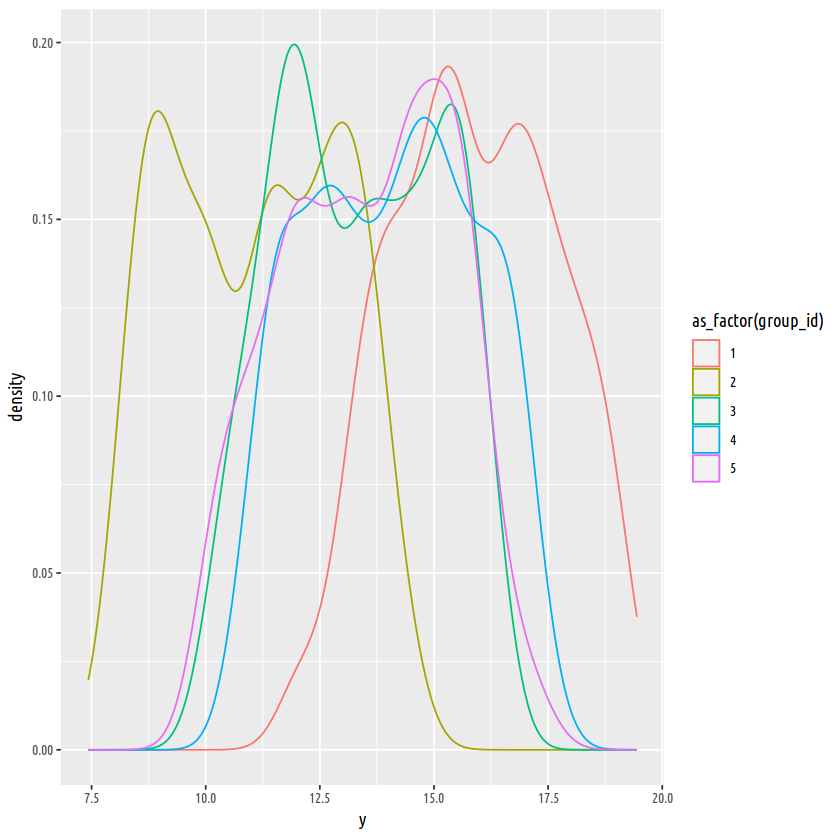

In [22]:
data_df %>%
    ggplot() +
    # geom_density(aes(x = y))
    # geom_point(aes(x = x, y = y, color = as_factor(group_id)))
    geom_density(aes(x = y, group = as_factor(group_id), color = as_factor(group_id)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


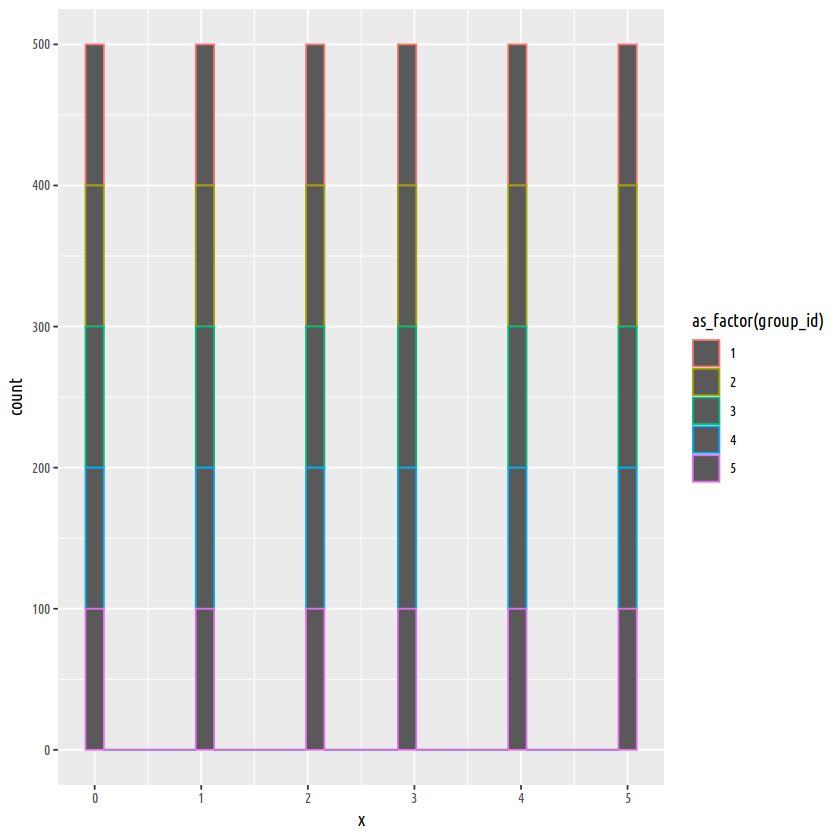

In [23]:
data_df %>%
    ggplot() +
    geom_histogram(aes(x = x, color = as_factor(group_id)))

In [24]:
data_df %>%
    write_csv(data_path)